Name: Antony Krymski

Username: agk-123

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

plt.style.use("bmh")
plt.rcParams.update({'font.size': 10})

def scale(a):
    # minmax scaling 
    maxv = np.max(a, axis=0)
    minv = np.min(a, axis=0)
    return (a - minv) / (maxv - minv) * 2. - 1.

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(np.floor(len(X) * (1 - test_size)))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

def plot(x):
    plt.figure(figsize=(16, 2))
    plt.margins(x=0, y=0)
    plt.plot(x)
    plt.show()

def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(16, 2))
    ax.margins(x=0, y=0)
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_timeseries(**kwargs):
    fig, (ax) = plt.subplots(1, 1, sharex=True, figsize=(16, 2))
    ax.margins(x=0, y=0)
    index = kwargs['index'] if 'index' in kwargs else None
    for key, value in kwargs.items():
        if key == 'title':
            ax.set_title(value)
        elif key == 'index':
            pass
        else:
            if index is None:
                ax.plot(value, label=key)
            else:
                ax.plot(index, value, label=key)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_training(history, metric='loss'):
    plot_timeseries(index=range(history.params['epochs']), title=metric, train=history.history[metric], test=history.history['val_' + metric])

In [3]:
WINDOWS = 10
TIMESTEPS = 25
FEATURES = 1
CODE_SIZE = 32
BATCH_SIZE = 256

# Data

# Pre-processing

In [4]:
# Download our time series 
timeseries = download('^SPX')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()
timeseries

Date
1970-01-05    0.004934
1970-01-06   -0.006871
1970-01-07   -0.002049
1970-01-08    0.000540
1970-01-09   -0.003026
                ...   
2024-08-20   -0.001987
2024-08-21    0.004231
2024-08-22   -0.008973
2024-08-23    0.011418
2024-08-26   -0.002959
Name: Close, Length: 13782, dtype: float64

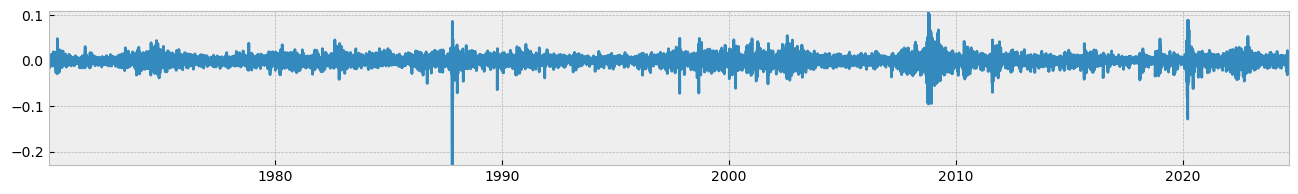

In [5]:
plot(timeseries)

Outliers 0.035878181362578504


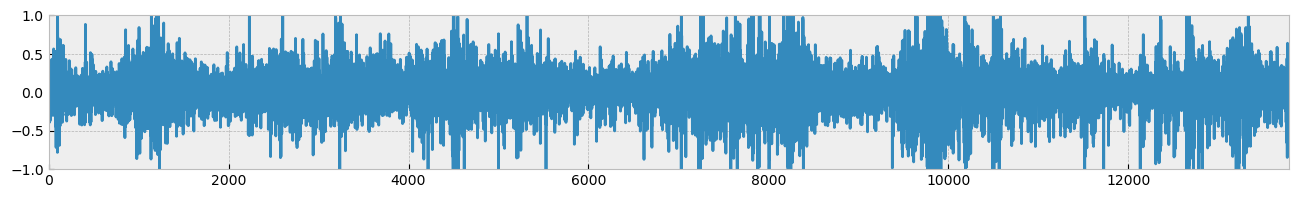

In [6]:
X = timeseries.values

# remove outliers
outliers = np.quantile(np.abs(X), 0.99)
X = np.clip(X, -outliers, outliers)
print('Outliers', outliers)

# scale
X = X / outliers

plot(X)

In [7]:
# generate lags
X = window(X, TIMESTEPS).astype(np.float32)
y = timeseries[TIMESTEPS:]

x_train, x_test, y_train, y_test = split(X, y, 0.2)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(X).all() == True)
assert(np.isfinite(y).all() == True)

(11005, 25) (2752, 25)
(11005,) (2752,)


In [8]:
evals = pd.DataFrame(index=['RMSE', 'MAE'])

def eval(name, y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    evals[name] = [ rmse, mae ]

In [9]:
# Base cases
eval('Persistence', y_test.shift(1).fillna(0), y_test)
eval('Zero', np.zeros(len(y_test)), y_test)
eval('Mean', np.full(len(y_test), np.mean(x_train[:, -1])), y_test)
evals

,Persistence,Zero,Mean
RMSE,0.016466,0.010951,0.013640
MAE,0.010473,0.007134,0.010261


In [41]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
eval('LR', model.predict(x_test), y_test)

In [42]:
# # ARIMA
# import pmdarima as pm
# model = pm.auto_arima(x_train[:, -1], stationary=True, maxiter=5)
# eval('ARIMA', model.predict(len(x_test)), y_test)

Epoch 1/5
43/43 [==============================] - 3s 31ms/step - loss: 2.2375e-04 - mae: 0.0100 - val_loss: 1.2073e-04 - val_mae: 0.0072
Epoch 2/5
43/43 [==============================] - 1s 17ms/step - loss: 1.4095e-04 - mae: 0.0084 - val_loss: 1.2241e-04 - val_mae: 0.0074
Epoch 3/5
43/43 [==============================] - 1s 15ms/step - loss: 1.3628e-04 - mae: 0.0082 - val_loss: 1.4394e-04 - val_mae: 0.0088
Epoch 4/5
43/43 [==============================] - 1s 16ms/step - loss: 1.2987e-04 - mae: 0.0080 - val_loss: 1.1978e-04 - val_mae: 0.0071
Epoch 5/5
43/43 [==============================] - 1s 15ms/step - loss: 1.2928e-04 - mae: 0.0079 - val_loss: 1.2026e-04 - val_mae: 0.0072


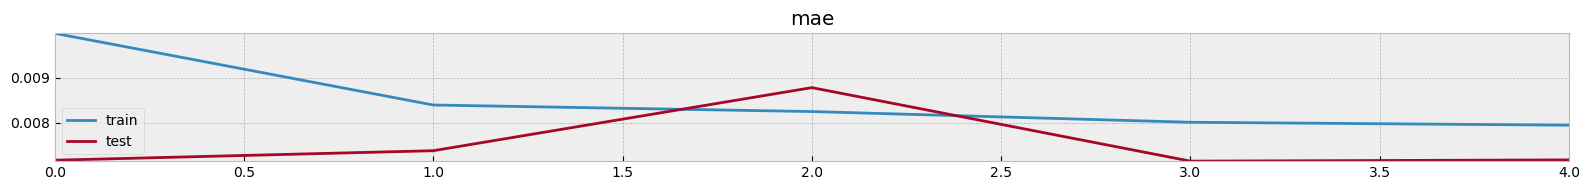

86/86 [==============================] - 1s 3ms/step


In [43]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(x_test, y_test))
plot_training(history, 'mae')

eval('LSTM', model.predict(x_test), y_test)

In [44]:
evals

,Persistence,Zero,Mean,LR,LSTM
RMSE,0.016466,0.010951,0.013640,0.011049,0.010966
MAE,0.010473,0.007134,0.010261,0.007189,0.007163


# Data Generation

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS):
        self.timesteps = timesteps
        self.n_windows = n_windows
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - (timesteps * n_windows) - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        return self.data[idx:idx+self.timesteps, 0]
    
    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            windows = []
            for w in range(self.n_windows):
                window = self.get_window(idx + (w * self.timesteps))
                windows.append(window)

            y_positive = self.get_window(idx + (self.n_windows * self.timesteps))

            y_negative = self.get_window(idx + ((self.n_windows-1) * self.timesteps))
            y_negative = np.random.normal(np.mean(y_negative), np.std(y_negative), len(y_negative))

            # positive sample
            x.append(windows)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(windows)
            y.append(y_negative)
            labels.append(0)
        
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        labels = np.array(labels).astype(np.float32)

        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        
        return (x, y), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

Batches: 41
x shape: (256, 10, 25, 1), y shape: (256, 25, 1), labels shape: (256,)


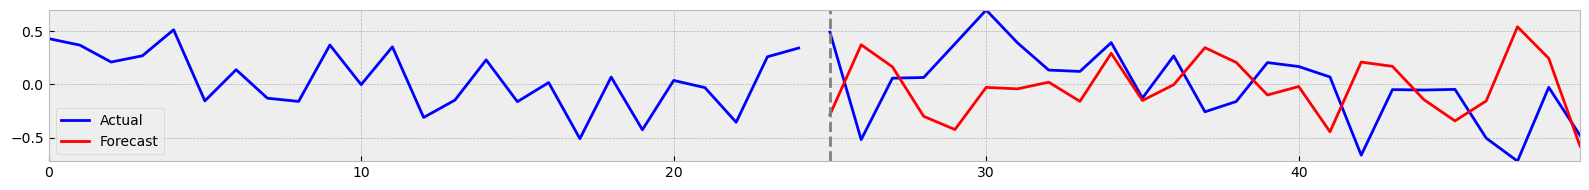

In [11]:
# Test generator
dg = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
print('Batches:', len(dg))

# Get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

plot_forecast(bx[0, -1, :, 0], by[0, :, 0], by[1, :, 0])

# CPC Model Architecture

In [16]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same', name="Conv1d_1")(input)
    x = Conv1D(64, 3, activation='relu', padding='same', name="Conv1d_2")(x)
    x = Flatten(name="Flatten")(x)
    # x = Dropout(0.5)(x)
    x = Dense(code_size, activation='linear', name='Encoder_Embedding')(x)
    return Model(input, x, name='Encoder')

encoder = build_encoder((TIMESTEPS, FEATURES), CODE_SIZE)
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 Conv1d_1 (Conv1D)           (None, 25, 64)            256       
                                                                 
 Conv1d_2 (Conv1D)           (None, 25, 64)            12352     
                                                                 
 Flatten (Flatten)           (None, 1600)              0         
                                                                 
 Encoder_Embedding (Dense)   (None, 32)                51232     
                                                                 
Total params: 63,840
Trainable params: 63,840
Non-trainable params: 0
_________________________________________________________________


In [17]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    # x = LSTM(128, return_sequences=True, name="context")(input)
    x = LSTM(64, return_sequences=False, name="Context")(input)
    x = Dense(code_size, activation="linear", name="Preds")(x)
    return Model(input, x, name="Context")

context = build_context((WINDOWS, CODE_SIZE), CODE_SIZE)
context.summary()

Model: "Context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10, 32)]          0         
                                                                 
 Context (LSTM)              (None, 64)                24832     
                                                                 
 Preds (Dense)               (None, 32)                2080      
                                                                 
Total params: 26,912
Trainable params: 26,912
Non-trainable params: 0
_________________________________________________________________


In [18]:
x_input = Input((WINDOWS, TIMESTEPS, FEATURES))
x_encoded = TimeDistributed(encoder)(x_input)

y_pred = context(x_encoded)
# y_pred = x_encoded[-1]

y_input = Input((TIMESTEPS, FEATURES))
y_encoded = encoder(y_input)

output = K.mean(y_encoded * y_pred, axis=-1)
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10, 25, 1)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 25, 1)]      0           []                               
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 10, 32)      63840       ['input_7[0][0]']                
 buted)                                                                                           
                                                                                                  
 Encoder (Functional)           (None, 32)           63840       ['input_8[0][0]']              

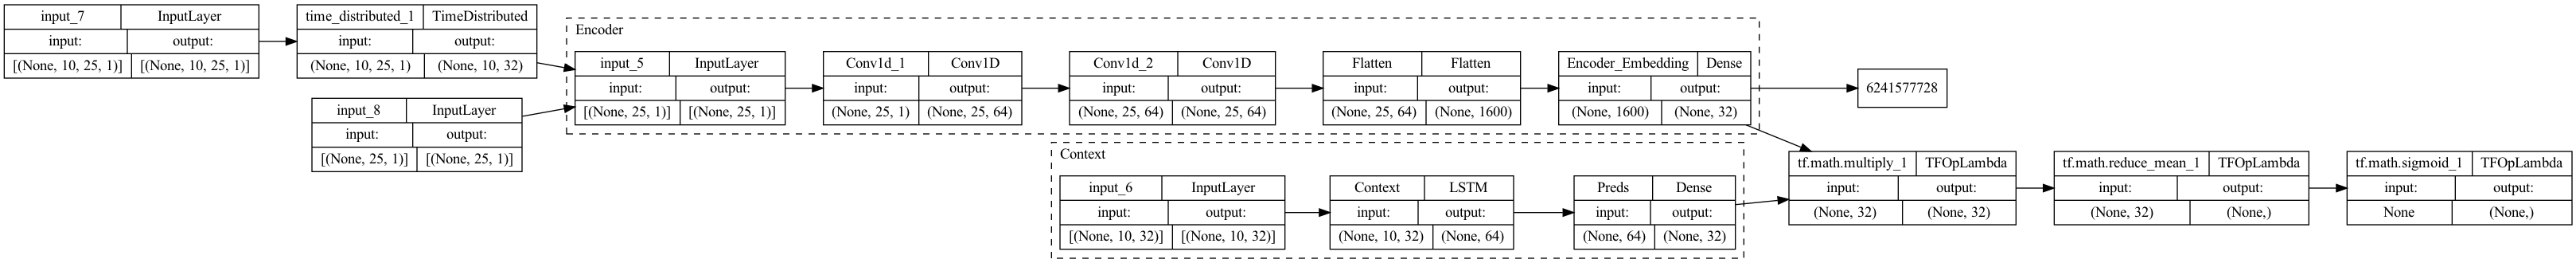

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR', 
    expand_nested=True
)

In [25]:
# # To use TensorBoard
# %load_ext tensorboard
# %tensorboard --logdir logs

In [124]:
train_gen = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=BATCH_SIZE, shuffle=True)

In [134]:
history = model.fit(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10
41/41 [==============================] - 2s 60ms/step - loss: 0.5368 - binary_accuracy: 0.7243 - val_loss: 0.6098 - val_binary_accuracy: 0.6780
Epoch 2/10
41/41 [==============================] - 2s 41ms/step - loss: 0.5370 - binary_accuracy: 0.7249 - val_loss: 0.6172 - val_binary_accuracy: 0.6745
Epoch 3/10
41/41 [==============================] - 2s 42ms/step - loss: 0.5246 - binary_accuracy: 0.7345 - val_loss: 0.6370 - val_binary_accuracy: 0.6589
Epoch 4/10
41/41 [==============================] - 2s 50ms/step - loss: 0.5397 - binary_accuracy: 0.7218 - val_loss: 0.6335 - val_binary_accuracy: 0.6471
Epoch 5/10
41/41 [==============================] - 2s 49ms/step - loss: 0.5338 - binary_accuracy: 0.7278 - val_loss: 0.6142 - val_binary_accuracy: 0.6675
Epoch 6/10
41/41 [==============================] - 2s 47ms/step - loss: 0.5219 - binary_accuracy: 0.7379 - val_loss: 0.6491 - val_binary_accuracy: 0.6610
Epoch 7/10
41/41 [==============================] - 2s 50ms/step - los

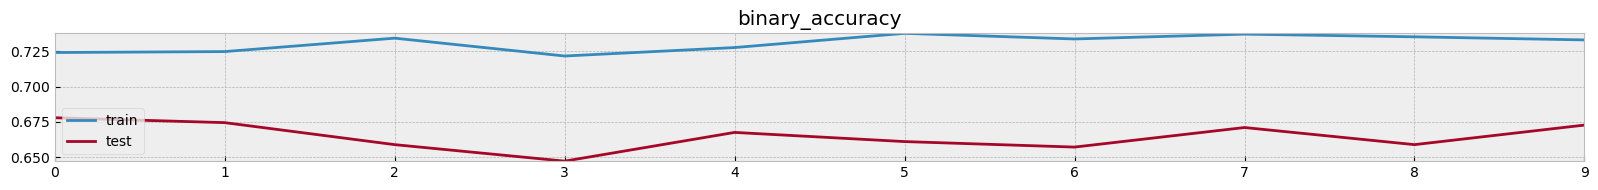

In [136]:
plot_training(history, 'binary_accuracy')

In [139]:
encoder.save('encoder.h5')

# Downstream Task

In [219]:
encoder = load_model('encoder.h5', compile=True)

In [220]:
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)

86/86 [==============================] - 0s 2ms/step


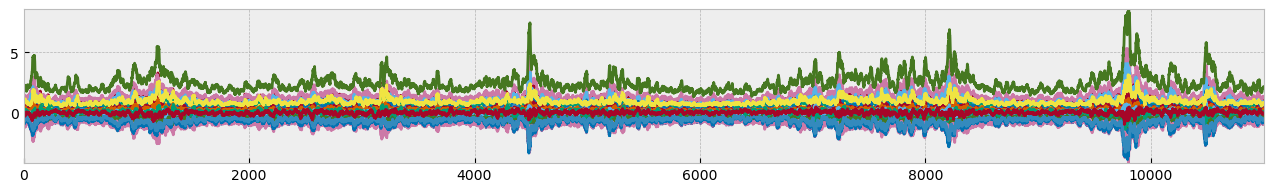

In [221]:
plot(x_train_embeds)

In [222]:
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)

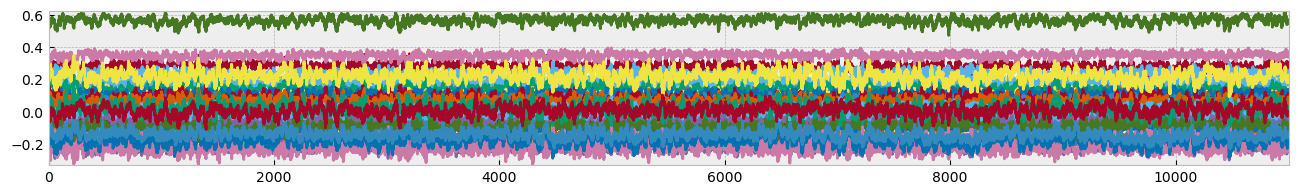

In [223]:
plot(x_train_embeds)

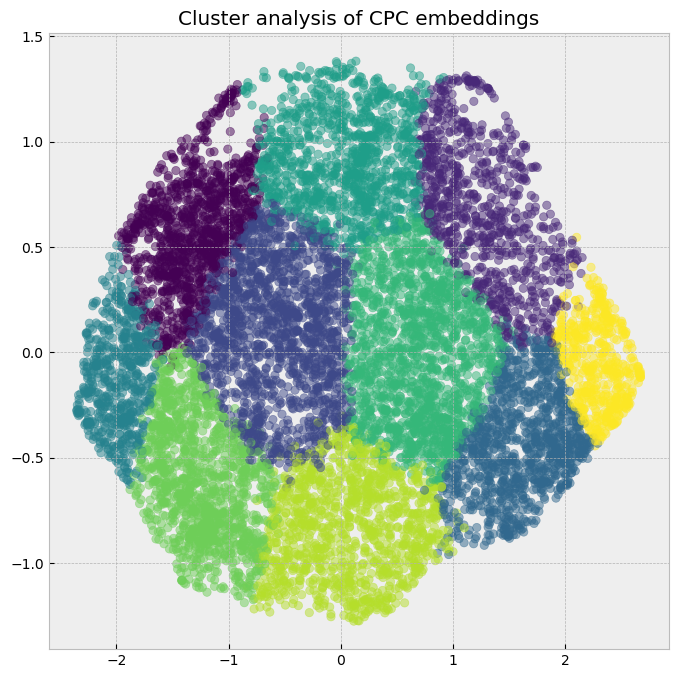

In [204]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=250)
embeddings_tsne = tsne.fit_transform(x_train_embeds)

# Apply K-means clustering
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(x_train_embeds)

# Visualize the clusters using the t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Cluster analysis of CPC embeddings')
plt.show()

In [224]:
# Linear Regression with CPC embeddings
model = LinearRegression()
model.fit(x_train_embeds, y_train)
eval('CPC-LR', model.predict(x_test_embeds), y_test)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_36 (Dense)            (None, 64)                2112      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable 

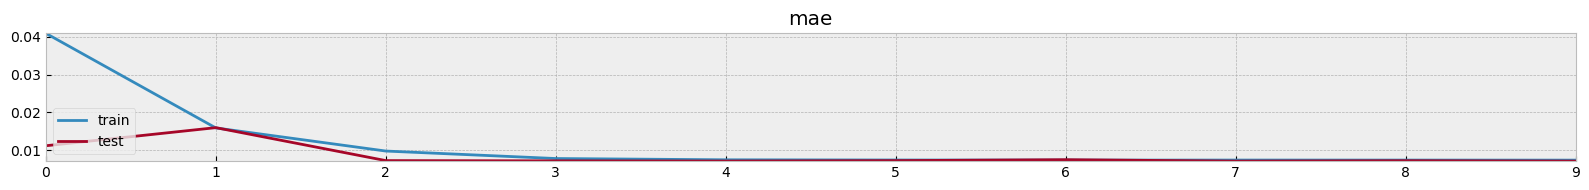

86/86 [==============================] - 0s 3ms/step


In [226]:
def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss='mse', metrics=['mae'])
model.summary()

history = model.fit(x_train_embeds, y_train, batch_size=BATCH_SIZE, epochs=10, validation_data=(x_test_embeds, y_test))
plot_training(history, 'mae')

eval('CPC', model.predict(x_test_embeds), y_test)

In [227]:
evals

,Persistence,LR,ARIMA,LSTM,LSTM2,CPC-LSTM,CPC-LR,CPC,Zero,Mean,EWMA
RMSE,0.016467,0.011458,0.011481,0.011021,0.010969,0.011667,0.010975,0.010945,0.010954,0.011486,0.026423
MAE,0.010476,0.007735,0.007762,0.007191,0.007152,0.008007,0.007155,0.007115,0.007137,0.007768,0.020928


# Optimize Sharpe

In [279]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_54 (Dense)            (None, 64)                2112      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 64)                4160      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable 

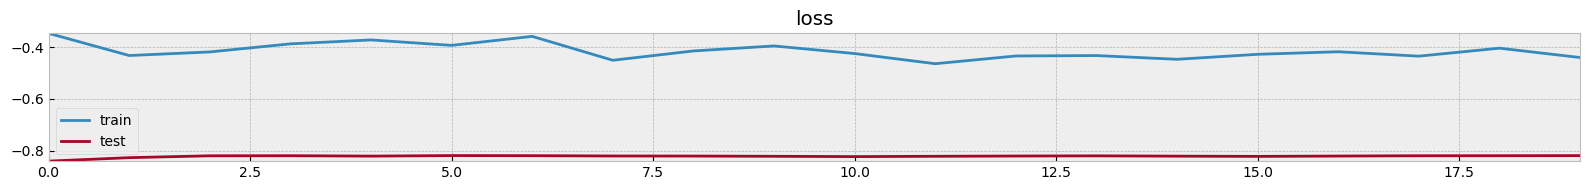

In [292]:
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    if (std_return <= 0): return 0.
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

def sharpe_loss(log_returns, allocations):
    portfolio_returns = log_returns[1:, 0] * allocations[:-1, 0]
    # Negative Sharpe ratio (to maximize it)
    return -sharpe_ratio(portfolio_returns)

def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss=sharpe_loss)
model.summary()

history = model.fit(x_train_embeds, train_returns, batch_size=250, epochs=20, validation_data=(x_test_embeds, test_returns))
plot_training(history, 'loss')


In [293]:
allocations = model.predict(x_test_embeds)[:, 0]
portfolio_returns = test_returns[1:] * allocations[:-1]
sharpe_ratio(portfolio_returns).numpy()

86/86 [==============================] - 0s 2ms/step


0.6273259802317829

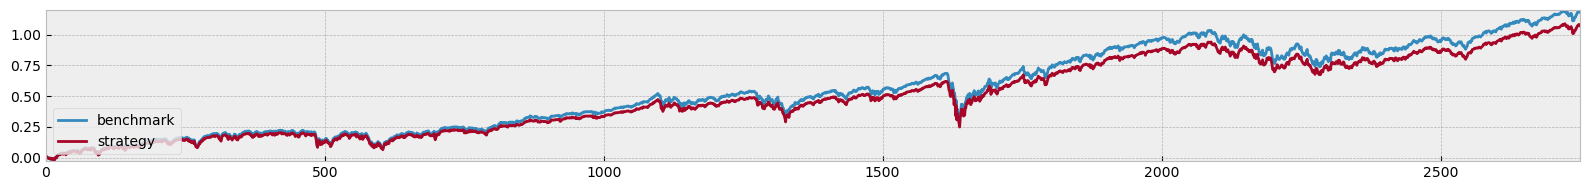

In [295]:
plot_timeseries(index=np.arange(len(x_test)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

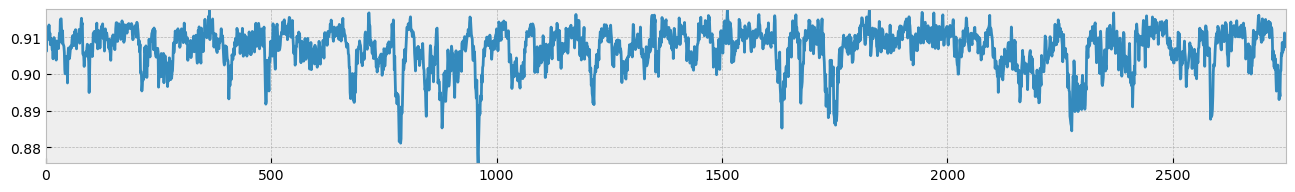

In [296]:
plot(allocations)